In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Problem 1: Use the IMDB Movie review dataset:

In [2]:
import pandas as pd
import numpy as np
import keras

In [3]:
df= pd.read_csv(r'/content/drive/MyDrive/IMDB Dataset.csv.zip') #importing the IMDB data

In [4]:
df.head(4)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative


In [5]:
df.sentiment.value_counts() 

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [6]:
df.isna().sum() # checking for null

review       0
sentiment    0
dtype: int64

In [7]:
df.dtypes

review       object
sentiment    object
dtype: object

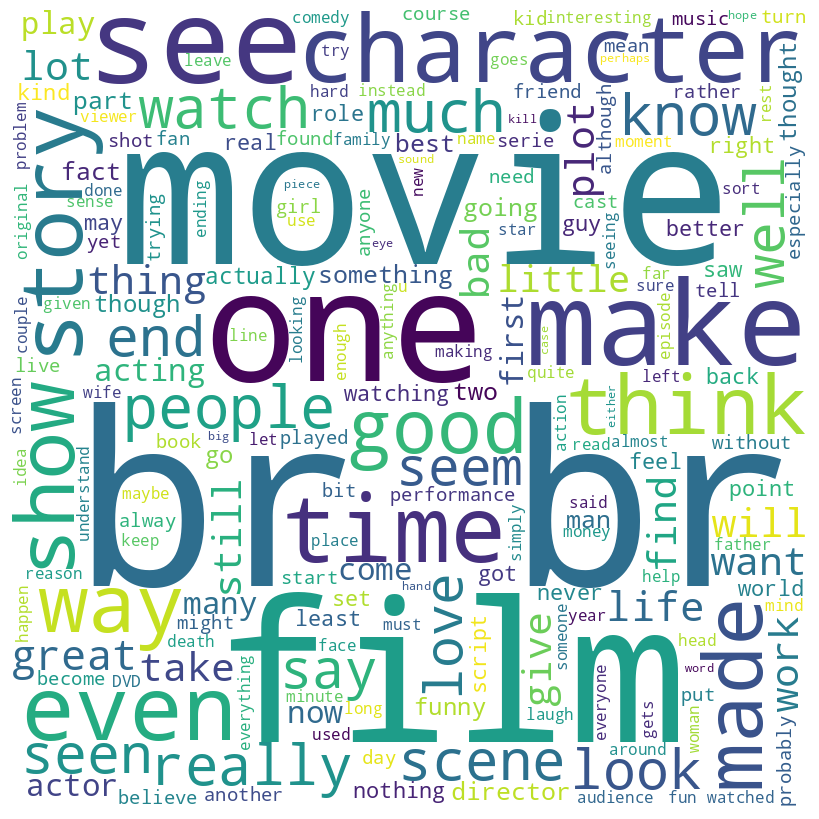

In [8]:
# word cloud 

from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Concatenating all reviews into a single string
text = ' '.join(df['review'].tolist())

# Generating the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

# Plotting the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


## 1.  Perform Text Preprocessing
## a. Tokenization
## b. Stopwords removing
## c. HTML removing
## d. Convert to lower case
## e. Lemmatization/stemming

In [5]:
! pip install contractions #installing the library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 18.3 MB/s eta 0:00:00


In [6]:
from contractions import contractions_dict

In [7]:
#importing the libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [8]:
# Defining the stopword list and the lemmatizer
stopwords_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [13]:
# Defining a function for preprocessing
def preprocess_text(text):
    
    # Removing HTML tags
    text = re.sub('<[^>]+>', '', text)
    
    # Converting to lower case
    text = text.lower()
    
    # Expanding contractions
    words = []
    for word in word_tokenize(text):
        if word in contractions_dict:
            words.extend(word_tokenize(contractions_dict[word]))
        else:
            words.append(word)
    
    # Removing punctuation
    words = [word for word in words if word.isalpha()]
    
    # Removing stopwords
    words = [word for word in words if word not in stopwords_list]
    
    # Lemmatizing
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Joining the words back into a single string
    text = ' '.join(words)
    
    return text


In [14]:
df['preprocessed_review'] = df['review'].apply(lambda x: preprocess_text(x)) 
#adding the new column for preprocessed words

In [15]:
df.head(4)

,review,sentiment,preprocessed_review
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically family little boy jake think zombie ...


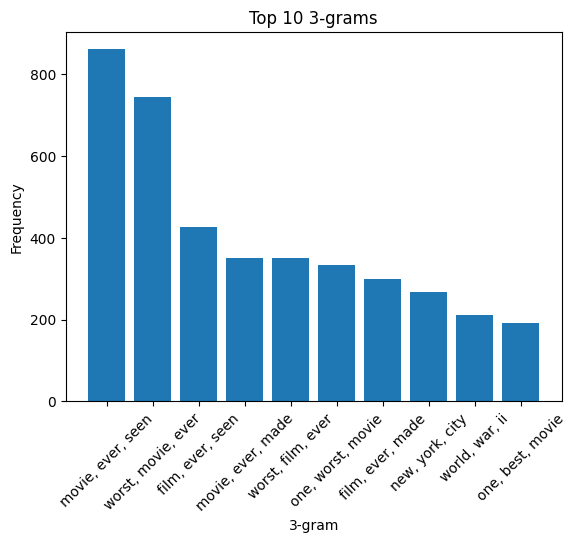

In [28]:
from nltk import ngrams
from collections import Counter

# Define the text
text = " ".join(df.preprocessed_review.tolist())

# Generating the tri-grams
n = 3
ngrams_list = ngrams(text.split(), n)
ngrams_freq = Counter(ngrams_list)

# Plotting the top 10 most frequent words
top_ngrams = ngrams_freq.most_common(10)
x_labels = [', '.join(words) for words, count in top_ngrams]
y_values = [count for words, count in top_ngrams]

plt.bar(x_labels, y_values)
plt.xticks(rotation=45)
plt.xlabel(f'{n}-gram')
plt.ylabel('Frequency')
plt.title(f'Top 10 {n}-grams')
plt.show()


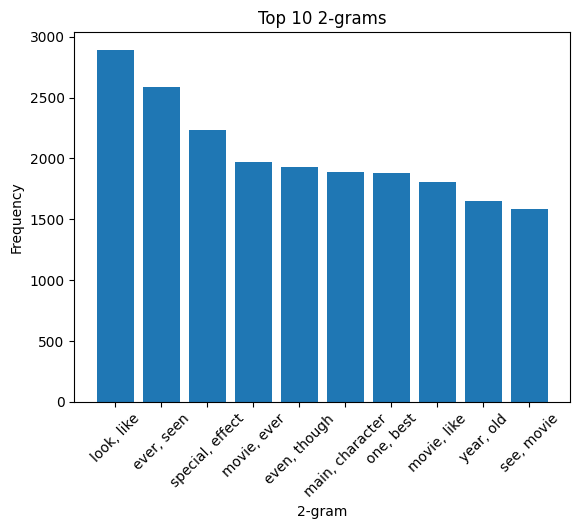

In [25]:
# Define the text
text = " ".join(df.preprocessed_review.tolist())

# Generating the bi-grams
n = 2
ngrams_list = ngrams(text.split(), n)
ngrams_freq = Counter(ngrams_list)

# Plotting the top 10 most frequent words
top_ngrams = ngrams_freq.most_common(10)
x_labels = [', '.join(words) for words, count in top_ngrams]
y_values = [count for words, count in top_ngrams]

plt.bar(x_labels, y_values)
plt.xticks(rotation=45)
plt.xlabel(f'{n}-gram')
plt.ylabel('Frequency')
plt.title(f'Top 10 {n}-grams')
plt.show()

## 2. Build the sentiment analysis model using: Word2Vec (CBoW) + LSTM

In [19]:
from keras.preprocessing.text import Tokenizer #importing the libraries
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

In [11]:
from gensim.models import Word2Vec #importing the pretrained Word2vec Model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [18]:
labels = np.array(df['sentiment'].map({'positive': 1, 'negative': 0})) # labelling the sentiment(target) column

In [19]:
# splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_review'], labels, test_size=0.2, random_state=42, stratify= labels)

### Model Architecture

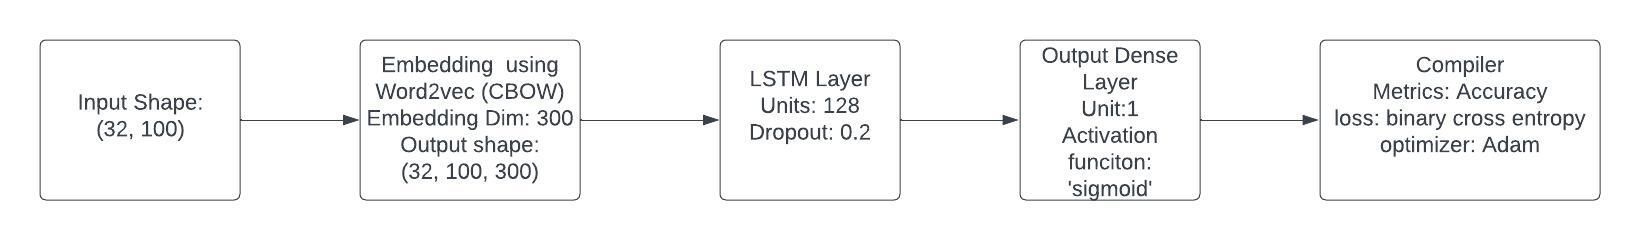

The first layer is an Embedding layer which takes in the input of shape (32, 100) and returns the embedded representation of each word in the input sequence. The embedding matrix is initialized with pre-trained word2vec vectors. The output shape of the Embedding layer is (32, 100, 300), where 100 is the length of the input sequence, and 300 is the dimension of the word embedding.

The second layer is an LSTM layer with 128 units. It takes in the embedded representation of the input sequence and returns the hidden state of the LSTM layer, which is a vector of size 128. The LSTM layer is used to capture the long-term dependencies between the words in the input sequence.

The third layer is a Dense layer with one unit, which takes in the hidden state of the LSTM layer and returns the output of the model. The output is a scalar value that represents the sentiment of the input text.

# **Hyper-parameter**: 


## Word2vec
1. embedding dimension= 300
2. sg= 0 ( CBOW)

## Hidden Layer:
1. Number of  LSTM Layers : 1 with 128 units 
2. Dropout percent = 0.2

##Output Layer: 
1. unit= 1
2. Activation Function: Sigmoid

##Fitting the model:
1. Epochs= 10
2. Batch size = 32

In [20]:
# Preprocess the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index
max_length= 100 # taking the max length as 100
train_data = pad_sequences(train_sequences, maxlen=max_length)
test_data = pad_sequences(test_sequences, maxlen=max_length)


In [23]:
train_data.shape, test_data.shape

((40000, 100), (10000, 100))

In [21]:
# building Word2Vec embeddings for train data

# Training the Word2Vec model with embedding dimension = 300
w2v_model = Word2Vec(train_sequences, vector_size=300, window=5, min_count=1, workers=4, sg=0)

In [22]:
# Creating the embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    try:
        embedding_vector = w2v_model.wv[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

In [245]:
# Defining the LSTM model
model = Sequential()
model.add(Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2)) #LSTM WITH 128 Units and Dropout = 0.2
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [246]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 100, 300)          24201000  
                                                                 
 lstm_2 (LSTM)               (None, 128)               219648    
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 24,420,777
Trainable params: 219,777
Non-trainable params: 24,201,000
_________________________________________________________________


The model has a total of 24,420,777 parameters, out of which 219,777 are trainable parameters and 24,201,000 are non-trainable parameters.

The summary of the model shows three layers:

The first layer is an Embedding layer, which takes the input sequences of length 100 and converts them into dense vectors of size 300. This layer has a total of 24,201,000 non-trainable parameters, which correspond to the pre-trained Word2Vec embeddings used.
The second layer is an LSTM layer with 128 hidden units. This layer has a total of 219,648 trainable parameters.
The last layer is a Dense layer with one output unit, used for binary classification. This layer has a total of 129 trainable parameters.

### Training the Model

In [ ]:
history1 = model.fit(train_data, y_train, epochs=10,batch_size= 32, validation_split= 0.2)
# training the model with 10 epochs and batch size = 32

Epoch 1/10
1000/1000 [==============================] - 159s 156ms/step - loss: 0.6933 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4989
Epoch 2/10
1000/1000 [==============================] - 154s 154ms/step - loss: 0.6933 - accuracy: 0.4942 - val_loss: 0.6931 - val_accuracy: 0.5011
Epoch 3/10
1000/1000 [==============================] - 154s 154ms/step - loss: 0.6932 - accuracy: 0.4982 - val_loss: 0.6931 - val_accuracy: 0.4989
Epoch 4/10
1000/1000 [==============================] - 154s 154ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.5011
Epoch 5/10
1000/1000 [==============================] - 154s 154ms/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.5011
Epoch 6/10
1000/1000 [==============================] - 155s 155ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 7/10
 296/1000 [=======>......................] - ETA: 1:42 - loss: 0.6932 - accuracy: 0.5010

### Prediction

In [248]:
# predict the sentiment labels for the test set
pred1 = model.predict(test_data)

313/313 [==============================] - 11s 34ms/step


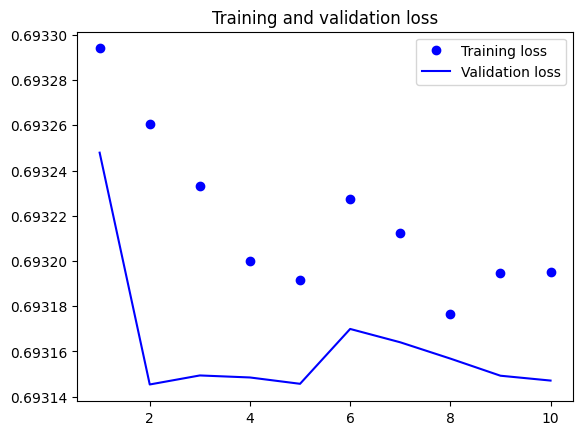

In [251]:
# print loss per epoch for both training and validation set.
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1,11)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [252]:
prediction1 = np.where(pred1 > 0.5 , 1, 0) # changing the probablities to labels with threshold = 0.5

### Metrics

In [253]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [254]:
# evaluating the performance of model on test data
test_loss, test_acc = model.evaluate(test_data, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 12s 36ms/step - loss: 0.6932 - accuracy: 0.5000
Test loss: 0.6931573748588562
Test accuracy: 0.5


In [255]:
# calculate the accuracy score of the Word2Vec + GaussianNB model
accuracy1 = accuracy_score(y_test.reshape(-1,1), prediction1)
print("Accuracy Score is ", accuracy1)

Accuracy Score is  0.5


In [256]:
cm = confusion_matrix(y_test.reshape(-1,1), prediction1) 
#printing the confusion matrix to see corrrect and wrong predicted values
print(cm)

[[   0 5000]
 [   0 5000]]


<Axes: >

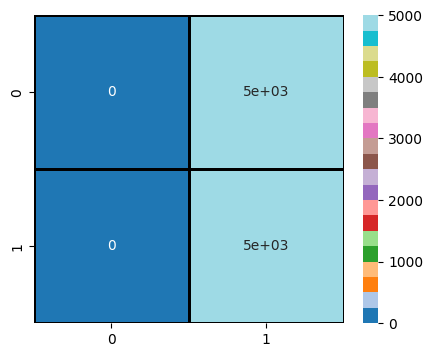

In [257]:
plt.figure(figsize=(5,4)) # visualising the confusion matrix in heatmap
sns.heatmap(cm,annot=True, cmap= 'tab20',linewidths=1, linecolor= 'black')

In [258]:
precision2 = precision_score(y_test, prediction1)
print("Precision Score is ", precision2)

Precision Score is  0.5


In [259]:
recall2 = recall_score(y_test, prediction1)
print("Recall Score is ", recall2)

Recall Score is  1.0


In [260]:
f1score2 = f1_score(y_test, prediction1)
print("F1 Score is ", f1score2)

F1 Score is  0.6666666666666666


## 3. First part of this question, use Keras embedding layer (+ GRU) for sentiment analysis. As a byproduct, you will achieve word embeddings for all the words used to train the model. In the second step, use cosine similarity to find the first five most similar words to "movie"

In [9]:
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [25]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_review'], labels, test_size=0.2, random_state=42)

In [26]:
# Preprocessting the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index
max_length= 100 #taking the max length as 100
X_train = pad_sequences(sequences_train, maxlen=max_length)
X_test = pad_sequences(sequences_test, maxlen=max_length)

In [27]:
X_train.shape

(40000, 100)

### Model Architecture

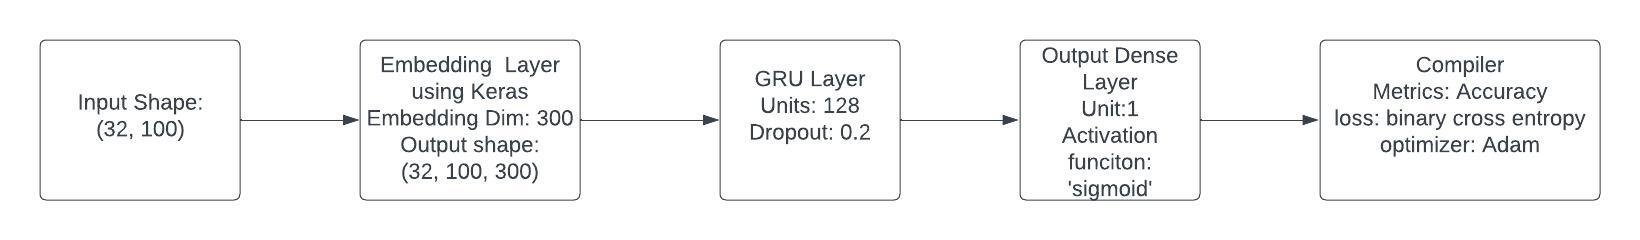

The input layer is an embedding layer that transforms the input text data into a dense vector space of shape 
(32,100,300) . The GRU layer is a type of recurrent neural network layer that allows the model to consider the sequence of input data. The GRU layer has 128 units, which means it can learn 128 different features from the input data. Finally, the output layer is a dense layer with a single unit and a sigmoid activation function, which outputs a probability score between 0 and 1 indicating the likelihood of the input text belonging to a certain class.

### Hyper-parameter Used

# **Hyper-parameter**: 

## Embedding Layer
1. embedding dimension= 100
2. Embedding units = len(word_index) +1

## Hidden Layer:
1. Number of  GRU Layers : 1 with 128 units 
2. Dropout percent = 0.2

##Output Layer: 
1. unit= 1
2. Activation Function: Sigmoid

##Fitting the model:
1. Epochs= 10
2. Batch size = 32

In [46]:
# Defining the model
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=300, input_length=max_length))
model.add(GRU(units=128, dropout=0.2, recurrent_dropout=0.2)) #GRU with 128 units and drouput =0.2
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          24364500  
                                                                 
 gru (GRU)                   (None, 128)               165120    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 24,529,749
Trainable params: 24,529,749
Non-trainable params: 0
_________________________________________________________________


The model summary shows that there are a total of 24,529,749 parameters in the model. All of these parameters are trainable, and there are no non-trainable parameters. The model consists of an Embedding layer that takes input of shape (32, 100) and outputs shape (32, 100, 300). The embedding layer has a total of 24,364,500 trainable parameters. The output of the embedding layer is fed to a GRU layer, which has 165,120 trainable parameters. Finally, there is a dense layer with 129 trainable parameters, which produces an output of shape (32, 1)

### Training the Model

In [48]:
# Train the model
history2 = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split = 0.2)
#training the Model for 10 epochs and batch size= 32

Epoch 1/10
1000/1000 [==============================] - 225s 222ms/step - loss: 0.3693 - accuracy: 0.8365 - val_loss: 0.3001 - val_accuracy: 0.8740
Epoch 2/10
1000/1000 [==============================] - 171s 171ms/step - loss: 0.1645 - accuracy: 0.9379 - val_loss: 0.3314 - val_accuracy: 0.8711
Epoch 3/10
1000/1000 [==============================] - 166s 166ms/step - loss: 0.0632 - accuracy: 0.9784 - val_loss: 0.4509 - val_accuracy: 0.8581
Epoch 4/10
1000/1000 [==============================] - 164s 164ms/step - loss: 0.0284 - accuracy: 0.9909 - val_loss: 0.5347 - val_accuracy: 0.8626
Epoch 5/10
1000/1000 [==============================] - 164s 164ms/step - loss: 0.0162 - accuracy: 0.9949 - val_loss: 0.6828 - val_accuracy: 0.8522
Epoch 6/10
1000/1000 [==============================] - 162s 162ms/step - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.7768 - val_accuracy: 0.8505
Epoch 7/10
1000/1000 [==============================] - 163s 163ms/step - loss: 0.0073 - accuracy: 0.9976 - val_

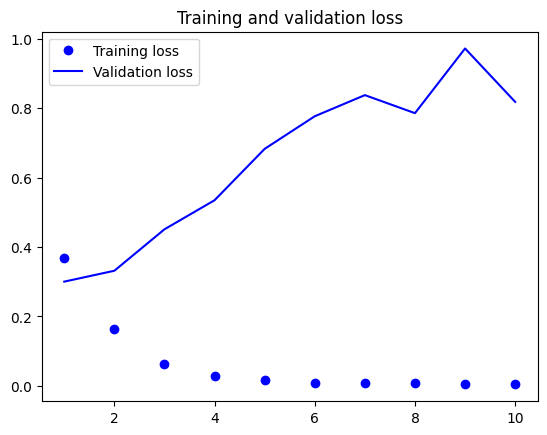

In [53]:
# printing loss per epoch for both training and validation set.
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1,11)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Prediction

In [56]:
pred2 = model.predict(X_test)

313/313 [==============================] - 9s 30ms/step


In [58]:
predictions2=  np.where(pred2 >= 0.5 ,1 ,0)

### Metrics

In [54]:
# evaluating the performance of model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 10s 31ms/step - loss: 0.7631 - accuracy: 0.8590
Test loss: 0.7631117105484009
Test accuracy: 0.859000027179718


In [61]:
cm = confusion_matrix(y_test, predictions2) 
#printing the confusion matrix to see corrrect and wrong predicted values
print(cm)

[[4246  715]
 [ 695 4344]]


<Axes: >

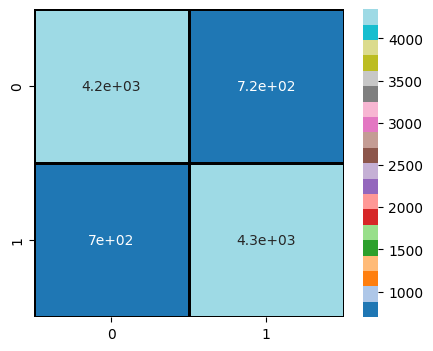

In [62]:
plt.figure(figsize=(5,4)) # visualising the confusion matrix in heatmap
sns.heatmap(cm,annot=True, cmap= 'tab20',linewidths=1, linecolor= 'black')

In [63]:
precision2 = precision_score(y_test, predictions2)
print("Precision Score is ", precision2)


Precision Score is  0.8586677208934572


In [65]:
recall2 = recall_score(y_test, predictions2)
print("Recall Score is ", recall2)

Recall Score is  0.8620758086922008


In [66]:
f1_score2 = f1_score(y_test, predictions2)
print("F1 Score is ", f1_score2)

F1 Score is  0.8603683897801544


### Using cosine similarity to find the first five most similar words to "movie"

In [49]:
# Getting word embeddings
embedding_matrix = model.layers[0].get_weights()[0]

In [50]:
# Finding the first five most similar words to "movie" using cosine similarity
word_vector = embedding_matrix[word_index['movie']]
similarity_scores = cosine_similarity(embedding_matrix, [word_vector])
most_similar_indices = similarity_scores.argsort(axis=0)[-6:-1][::-1]
most_similar_words = [word for word, index in word_index.items() if index in most_similar_indices]

print("The first five most similar words to 'movie' are:", most_similar_words)

The first five most similar words to 'movie' are: ['film', 'one', 'time', 'show', 'recommend']


# Problem 2: Use the mobydick chapter four dataset for text generation. In the process of text generation, you must develop a multiclass classification sequential model using GRU/LSTM/RNN. Your model should achieve a minimum accuracy of 20%. You should use minimum 25 tokens as X features and the immediate next token as y feature. The expectation of the generated text is that: it should not be all identical words and number of generated texts should be minimum of 20.

In [10]:
with open('/content/drive/MyDrive/mobydick_ch04.txt') as f:
    chapter4_text = f.read() # loading the text file


In [11]:
# Printing the extracted text
chapter4_text

'Call me Ishmael.  Some years ago--never mind how long\nprecisely--having little or no money in my purse, and nothing\nparticular to interest me on shore, I thought I would sail about a\nlittle and see the watery part of the world.  It is a way I have of\ndriving off the spleen and regulating the circulation.  Whenever I\nfind myself growing grim about the mouth; whenever it is a damp,\ndrizzly November in my soul; whenever I find myself involuntarily\npausing before coffin warehouses, and bringing up the rear of every\nfuneral I meet; and especially whenever my hypos get such an upper\nhand of me, that it requires a strong moral principle to prevent me\nfrom deliberately stepping into the street, and methodically knocking\npeople\'s hats off--then, I account it high time to get to sea as soon\nas I can.  This is my substitute for pistol and ball.  With a\nphilosophical flourish Cato throws himself upon his sword; I quietly\ntake to the ship.  There is nothing surprising in this.  If t

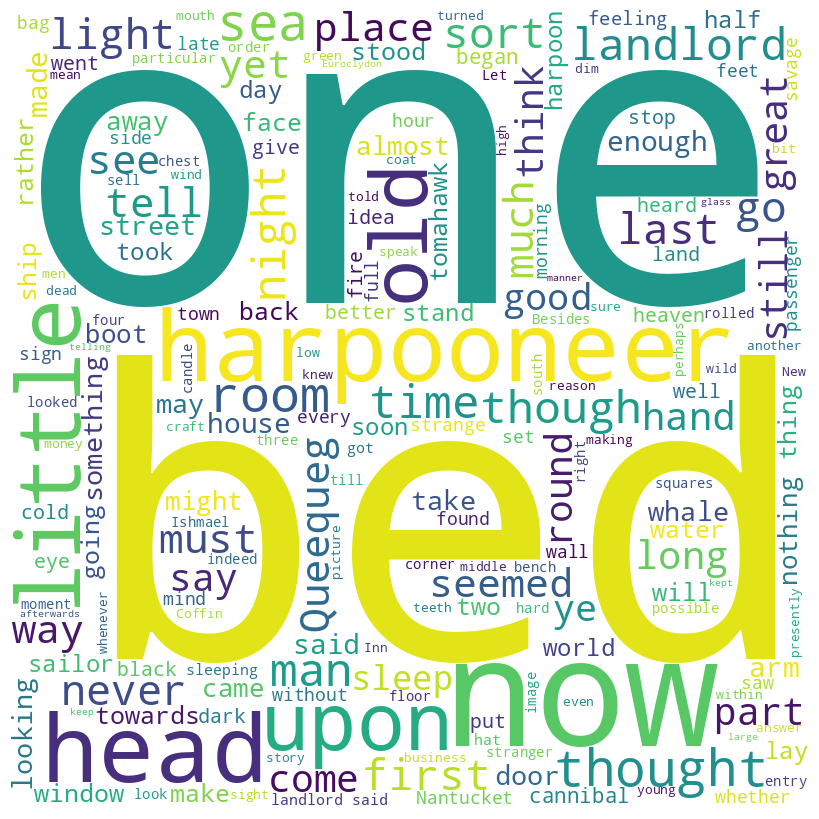

In [238]:
# Wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Concatenating all reviews into a single string
text = chapter4_text

# Generating the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

# Plotting the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

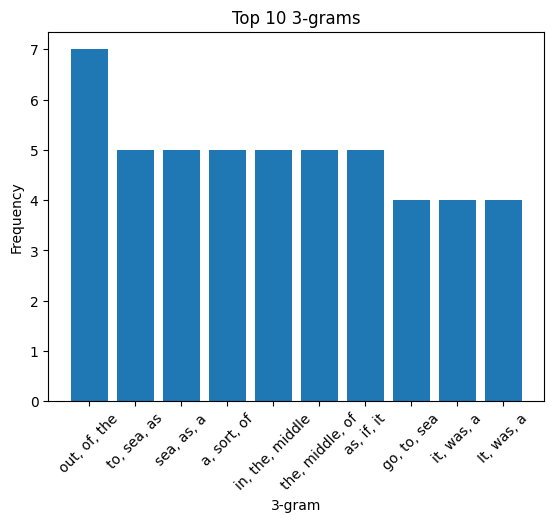

In [239]:
# Generating the tri-grams
n = 3
ngrams_list = ngrams(text.split(), n)
ngrams_freq = Counter(ngrams_list)

# Plotting the top 10 most frequent words
top_ngrams = ngrams_freq.most_common(10)
x_labels = [', '.join(words) for words, count in top_ngrams]
y_values = [count for words, count in top_ngrams]

plt.bar(x_labels, y_values)
plt.xticks(rotation=45)
plt.xlabel(f'{n}-gram')
plt.ylabel('Frequency')
plt.title(f'Top 10 {n}-grams')
plt.show()


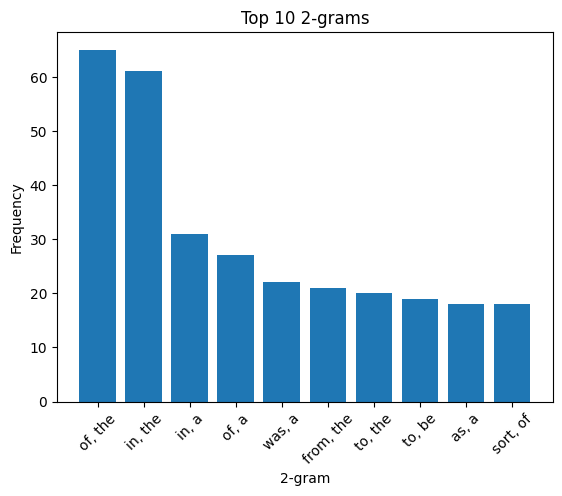

In [240]:
# Generating the bi-grams
n = 2
ngrams_list = ngrams(text.split(), n)
ngrams_freq = Counter(ngrams_list)

# Plotting the top 10 most frequent words
top_ngrams = ngrams_freq.most_common(10)
x_labels = [', '.join(words) for words, count in top_ngrams]
y_values = [count for words, count in top_ngrams]

plt.bar(x_labels, y_values)
plt.xticks(rotation=45)
plt.xlabel(f'{n}-gram')
plt.ylabel('Frequency')
plt.title(f'Top 10 {n}-grams')
plt.show()


## 1. Perform Text Preprocessing
## a. Tokenization
## b. Convert to lower case
## c. Expand contraction
## d. Remove punctuation
## e. Lemmatization/stemming

In [12]:
# Defining the stopword list and the lemmatizer
stopwords_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()


In [13]:
# Defining a function for preprocessing
def preprocess_text1(text):
    
    # Removing HTML tags
    text = re.sub('<[^>]+>', '', text)
    
    # Converting to lower case
    text = text.lower()
    
    # Expanding contractions
    words = []
    for word in word_tokenize(text):
        if word in contractions_dict:
            words.extend(word_tokenize(contractions_dict[word]))
        else:
            words.append(word)
    
    # Removing punctuation
    words = [word for word in words if word.isalpha()]
    
    # Removing stopwords
    words = [word for word in words if word not in stopwords_list]
    
    # Lemmatizing
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Joining the words back into a single string
    text = ' '.join(words)
    
    return text

In [14]:
chap4_preprocessed = preprocess_text1(chapter4_text) 

In [15]:
chap4_preprocessed # preprocessed text

'call ishmael year ago never mind long precisely little money purse nothing particular interest shore thought would sail little see watery part world way driving spleen regulating circulation whenever find growing grim mouth whenever damp drizzly november soul whenever find involuntarily pausing coffin warehouse bringing rear every funeral meet especially whenever hypo get upper hand requires strong moral principle prevent deliberately stepping street methodically knocking people hat account high time get sea soon substitute pistol ball philosophical flourish cato throw upon sword quietly take ship nothing surprising knew almost men degree time cherish nearly feeling towards ocean insular city manhattoes belted round wharf indian isle coral reef commerce surround surf right left street take waterward extreme downtown battery noble mole washed wave cooled breeze hour previous sight land look crowd circumambulate city dreamy sabbath afternoon go corlears hook coenties slip thence whiteha

## 2. Text generation model should be developed using keras word embeddings.

In [19]:
from nltk.tokenize import word_tokenize, sent_tokenize
import string

nltk.download('punkt')
nltk.download('wordnet')

text= chapter4_text

# Tokenization
sentences = sent_tokenize(text)

# Lowercasing conversion
sentences = [sentence.lower() for sentence in sentences]

# Expanding contractions
def expand_contractions(text):
    # contraction mapping
    for contraction, expansion in contractions_dict.items():
        text = text.replace(contraction, expansion)
    return text

sentences = [expand_contractions(sentence) for sentence in sentences]

# Removing punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("", "", string.punctuation))

sentences = [remove_punctuation(sentence) for sentence in sentences]

# Lemmatization
lemmatizer = WordNetLemmatizer()
sentences = [" ".join([lemmatizer.lemmatize(word) for word in word_tokenize(sentence)]) for sentence in sentences]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
sentences

['call me ishmael',
 'some year agonever mind how long preciselyhaving little or no money in my purse and nothing particular to interest me on shore i thought i would sail about a little and see the watery part of the world',
 'it is a way i have of driving off the spleen and regulating the circulation',
 'whenever i find myself growing grim about the mouth whenever it is a damp drizzly november in my soul whenever i find myself involuntarily pausing before coffin warehouse and bringing up the rear of every funeral i meet and especially whenever my hypo get such an upper hand of me that it requires a strong moral principle to prevent me from deliberately stepping into the street and methodically knocking people hat offthen i account it high time to get to sea a soon a i can',
 'this is my substitute for pistol and ball',
 'with a philosophical flourish cato throw himself upon his sword i quietly take to the ship',
 'there is nothing surprising in this',
 'if they but knew it almost all

In [21]:
len(sentences)

481

### Model Architecture

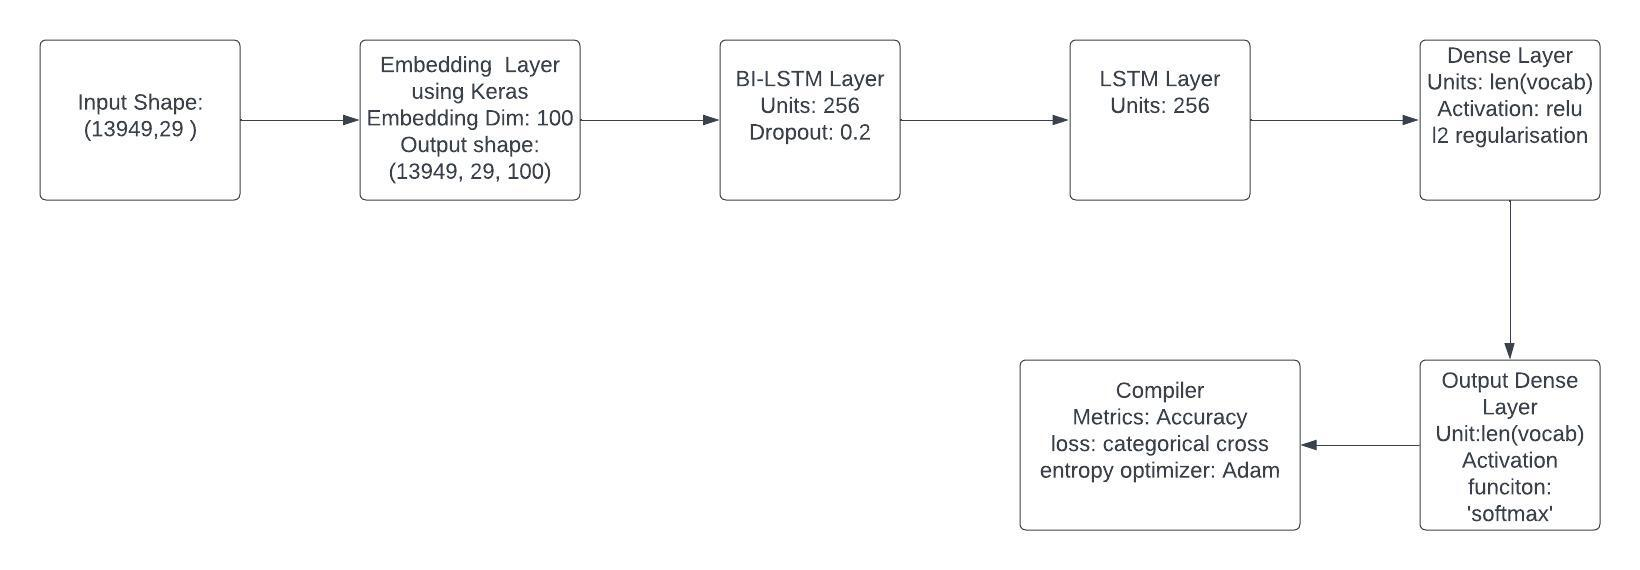

This is a text generation model consisting of the following layers:

An Embedding layer with input length of max_sequence_len-1 and output dimension of 100, which learns the dense representation of each word in the vocabulary.

A Bidirectional layer with an LSTM layer of 256 units and return sequence set to True. The Bidirectional layer allows the model to consider context from both directions of the input sequence.

A Dropout layer with a dropout rate of 0.2 to prevent overfitting.

Another LSTM layer with 256 units to further process the outputs from the previous layer.

A Dense layer with ReLU activation and kernel regularizer set to tf.keras.regularizers.l2(0.01), which applies L2 regularization to the weights matrix, to help prevent overfitting.

A final Dense layer with a softmax activation function, which outputs a probability distribution over the vocabulary, indicating the likelihood of each word being the next word in the sequence.

# **Hyper-parameter**: 

## Embedding Layer
1. embedding dimension= 100
2. Embedding units = len(vocab): 2640


## Hidden Layer:
1. BiDirectional LSTM : 1 with 256 units 
2. Dropout percent = 0.2
3. LSTM Layer: 256 units
4. Dense Layer: 2640 units with activation= relu and l2 regularisation

##Output Layer: 
1. unit= 2460 units
2. Activation Function: Softmax

##Fitting the model:
1. Epochs= 1500

In [28]:
sentences[1]

'some year agonever mind how long preciselyhaving little or no money in my purse and nothing particular to interest me on shore i thought i would sail about a little and see the watery part of the world'

In [31]:
vocab = set()

for i in sentences:
  for word in i.split(" "):
    vocab.add(word)

In [32]:
len(vocab) # total unique words in chapter 4

2640

In [36]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [37]:
max_vocab_size = len(vocab)


input_text_processor = tf.keras.layers.TextVectorization(
standardize = "lower_and_strip_punctuation",
max_tokens = max_vocab_size)

input_text_processor.adapt(sentences)

input_sequences = []
for sentence in sentences:
  token_sequence = input_text_processor(sentence)
  length = token_sequence.shape[0]

  for i in range(1, 30): # X of sequence length 29 
    n_gram_sequence = token_sequence[:i+1]
    input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]

label = tf.keras.utils.to_categorical(label, num_classes=max_vocab_size) #one hot encoding target

In [38]:
predictors.shape, label.shape

((13949, 29), (13949, 2640))

In [44]:
from keras.layers import Bidirectional, Dropout
from keras.layers import Dense, LSTM, Embedding

In [47]:
model = Sequential()
model.add(Embedding(len(vocab), 100, input_length = max_sequence_len-1))
model.add(Bidirectional(tf.keras.layers.LSTM(256,return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dense(len(vocab),activation = "relu",kernel_regularizer = tf.keras.regularizers.l2(0.01))) 
model.add(Dense(len(vocab), activation='softmax'))

In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 29, 100)           264000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 29, 512)          731136    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 29, 512)           0         
                                                                 
 lstm_6 (LSTM)               (None, 256)               787456    
                                                                 
 dense_2 (Dense)             (None, 2640)              678480    
                                                                 
 dense_3 (Dense)             (None, 2640)              6972240   
                                                      

The model summary shows that this is a neural network with the following layers and output shapes:

Embedding layer: input shape (None, 29), output shape (None, 29, 100), number of trainable parameters 264000
Bidirectional layer: input shape (None, 29, 100), output shape (None, 29, 512), number of trainable parameters 731136
Dropout layer: input shape (None, 29, 512), output shape (None, 29, 512), number of trainable parameters 0
LSTM layer: input shape (None, 29, 512), output shape (None, 256), number of trainable parameters 787456
Dense layer: input shape (None, 256), output shape (None, 2640), number of trainable parameters 678480
Dense layer: input shape (None, 2640), output shape (None, 2640), number of trainable parameters 6972240
The total number of trainable parameters in this model is 9,433,312.

In [49]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training

In [57]:
# training the Model
history7 = model.fit(predictors,label, epochs=1500, validation_split=0.1)

Epoch 1/1500
393/393 [==============================] - 4s 10ms/step - loss: 0.6339 - accuracy: 0.9144 - val_loss: 17.8842 - val_accuracy: 0.0337
Epoch 2/1500
393/393 [==============================] - 4s 9ms/step - loss: 0.6359 - accuracy: 0.9120 - val_loss: 18.1544 - val_accuracy: 0.0452
Epoch 3/1500
393/393 [==============================] - 4s 9ms/step - loss: 0.6151 - accuracy: 0.9166 - val_loss: 18.0822 - val_accuracy: 0.0487
Epoch 4/1500
393/393 [==============================] - 4s 10ms/step - loss: 0.6087 - accuracy: 0.9184 - val_loss: 18.1904 - val_accuracy: 0.0437
Epoch 5/1500
393/393 [==============================] - 4s 10ms/step - loss: 0.6223 - accuracy: 0.9140 - val_loss: 18.4709 - val_accuracy: 0.0480
Epoch 6/1500
393/393 [==============================] - 4s 10ms/step - loss: 0.6367 - accuracy: 0.9105 - val_loss: 18.5943 - val_accuracy: 0.0509
Epoch 7/1500
393/393 [==============================] - 4s 10ms/step - loss: 0.6230 - accuracy: 0.9140 - val_loss: 18.6339 - v

### Saving the Model

In [61]:
model.save_weights("/content/drive/MyDrive/mobydick_prediction_model.h5")

### Prediction (Generating Text)

### Generating 20 Text with minimum 20 words

In [62]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_sequence = input_text_processor([seed_text])[0]
        token_sequence = pad_sequences([token_sequence], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_sequence)[0]
        predicted_idx = np.argmax(predicted_probs)
        output_word = ""
        vocab_list = input_text_processor.get_vocabulary()
        vocab_dict = {word:idx for idx, word in enumerate(vocab_list)}
        for word, index in vocab_dict.items():
            if index == predicted_idx:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text



In [63]:
import random
output= []
# to generate 20 different texts
for i in range(20):
    # Pick a random line as the seed text
    seed_text = random.choice(sentences)
    generated_text = generate_text( seed_text, 40, model, max_sequence_len)
    output.append([seed_text, generated_text])

1/1 [==============================] - 0s 21ms/step


In [64]:
for i in output:
  print("Text from book is")
  print(i[0])
  print("--------")
  print("Generated Text is")
  print(i[1])
  print("\n")
  print("\n")

Text from book is
sartain and that is the very reason he can not sell it i guess
--------
Generated Text is
sartain and that is the very reason he can not sell it i guess to spoil the hilarity of his shipmate by his own sober face yet upon i fear and left me in all the little plan that had occurred to fear and left chase to fear and jumping a a passenger of




Text from book is
of thing not properly belonging to the room there wa a hammock lashed up and thrown upon the floor in one corner also a large seaman bag containing the harpooneer wardrobe no doubt in lieu of a land trunk
--------
Generated Text is
of thing not properly belonging to the room there wa a hammock lashed up and thrown upon the floor in one corner also a large seaman bag containing the harpooneer wardrobe no doubt in lieu of a land trunk a a light in all the entry the most craft concerning i a much a to sayi will not touch in an fountain feeling now and a heathen wa the most loving and penalty of his bed not to infa

### Metrics

In [65]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from keras.utils import pad_sequences

# Defining a function to calculate perplexity
def calculate_perplexity(model, X, y):
  
    loss, _ = model.evaluate(X, y, verbose=0)
    
    # Calculating perplexity
    perplexity = np.exp(loss)
    
    return perplexity


Perplexity measures how well a language model is able to predict the next word in a sequence of words.

Perplexity is calculated as the exponential of the cross-entropy loss of the language model on a validation set. It is a measure of how well the model is able to predict the next word in a sequence, given the preceding words. In text generation, lower perplexity can indicate that the generated text is more coherent and closer to the distribution of the training data. bold text

In [67]:
# Calculating perplexity on test data

perplexity = calculate_perplexity(model, predictors, label)
print(f'Text perplexity: {perplexity:.4f}')


Text perplexity: 10.8147


## 3. Transfer Learning: Text generation model should be developed using word2vec word embeddings

In [68]:
from gensim.models import Word2Vec #importing the pretrained Word2vec Model

In [69]:

# tokenize
tokens=[]
for i in sentences:
  words= i.split()
  tokens.extend(words)

In [70]:
len(tokens)

11099

In [71]:
# Training word2vec model
word2vec2 = Word2Vec([tokens], min_count=1, vector_size=100, sg=0, window=5)

In [72]:
# Defining sequence length and step size
seq_length = 29
step_size = 1

In [73]:
# Creating sequences of tokens and corresponding targets
sequences = []
targets = []
for i in range(0, len(tokens)-seq_length, step_size):
    sequences.append(tokens[i:i+seq_length])
    targets.append(tokens[i+seq_length])

In [74]:
# Converting tokens to word2vec embeddings
X = np.array([np.array([word2vec2.wv[token] for token in sequence]) for sequence in sequences])
y = np.array([word2vec2.wv[token] for token in targets])

In [75]:
# Converting tokens to word2vec embeddings
X = np.array([np.array([word2vec2.wv[token] for token in sequence]) for sequence in sequences])
y = np.eye(len(word2vec2.wv.index_to_key))[np.array([word2vec2.wv.key_to_index[token] for token in targets])]


In [76]:
X.shape, y.shape

((11070, 29, 100), (11070, 2640))

### Model Architecture

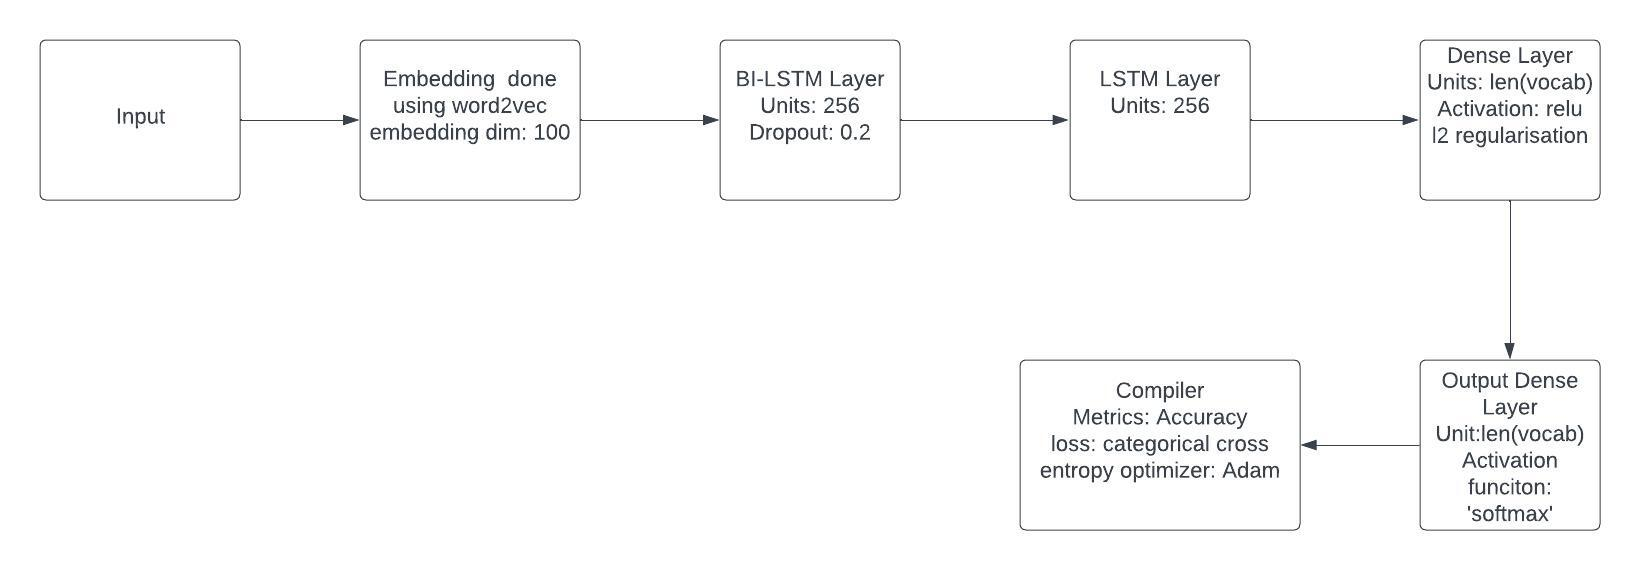

The given code implements a language model for text generation using a Bidirectional LSTM neural network with 256 units. The input data is passed through an embedding layer generated using pre-trained Word2Vec word embeddings to convert the text data into vector representation. The Bidirectional LSTM layer helps the network to capture the contextual information in both forward and backward directions. A dropout layer is added to avoid overfitting, and a regularizer is added to prevent overfitting by adding a penalty term to the loss function. Finally, there are two dense layers, the first one with 2000 units and the second one with the same number of units as the vocabulary size, followed by a softmax activation function to output the predicted probability distribution over the vocabulary. The model is compiled using the categorical cross-entropy loss function and the Adam optimizer.

# **Hyper-parameter**: 

## Embedding using Word2Vec
1. embedding dimension= 100


## Hidden Layer:
1. BiDirectional LSTM : 1 with 256 units 
2. Dropout percent = 0.2
3. LSTM Layer: 256 units
4. Dense Layer: 2640 units with activation= relu and l2 regularisation

##Output Layer: 
1. unit= 2460 units
2. Activation Function: Softmax

##Fitting the model:
1. Epochs= 150

In [81]:
# Defining the model

model = Sequential()
model.add(Bidirectional(tf.keras.layers.LSTM(256,return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dense(2640,activation = "relu",kernel_regularizer = tf.keras.regularizers.l2(0.01))) 
model.add(Dense(2640, activation='softmax'))



# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [84]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirectio  (None, 29, 512)          731136    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 29, 512)           0         
                                                                 
 lstm_12 (LSTM)              (None, 256)               787456    
                                                                 
 dense_8 (Dense)             (None, 2640)              678480    
                                                                 
 dense_9 (Dense)             (None, 2640)              6972240   
                                                                 
Total params: 9,169,312
Trainable params: 9,169,312
Non-trainable params: 0
____________________________________________

The model summary shows that the total number of parameters in the model is 9,169,312. All of these parameters are trainable. The architecture of the model includes:

A Bidirectional LSTM layer with 512 units and input shape of (batch_size, sequence_length, embedding_dimension).
A Dropout layer with a rate of 0.2 to prevent overfitting.
A LSTM layer with 256 units.
A Dense layer with 2640 units and ReLU activation function, which outputs a hidden representation of the input sequence.
Another Dense layer with 2640 units and Softmax activation function, which outputs the probability distribution over the vocabulary for each time step.
Overall, the model is designed for text generation tasks, with the goal of predicting the next word in a sequence given the previous words as input.

### Training the Model

In [85]:
# Training the model

history8= model.fit(X, y, epochs=150, validation_split= 0.1)

Epoch 1/150
312/312 [==============================] - 4s 13ms/step - loss: 6.0447 - accuracy: 0.0610 - val_loss: 6.0795 - val_accuracy: 0.0596
Epoch 2/150
312/312 [==============================] - 3s 9ms/step - loss: 6.0043 - accuracy: 0.0636 - val_loss: 6.1614 - val_accuracy: 0.0443
Epoch 3/150
312/312 [==============================] - 3s 9ms/step - loss: 5.9731 - accuracy: 0.0615 - val_loss: 6.2341 - val_accuracy: 0.0578
Epoch 4/150
312/312 [==============================] - 3s 9ms/step - loss: 5.9446 - accuracy: 0.0622 - val_loss: 6.2701 - val_accuracy: 0.0578
Epoch 5/150
312/312 [==============================] - 3s 9ms/step - loss: 5.9184 - accuracy: 0.0634 - val_loss: 6.3094 - val_accuracy: 0.0578
Epoch 6/150
312/312 [==============================] - 3s 9ms/step - loss: 5.8958 - accuracy: 0.0647 - val_loss: 6.3916 - val_accuracy: 0.0596
Epoch 7/150
312/312 [==============================] - 3s 9ms/step - loss: 5.8786 - accuracy: 0.0637 - val_loss: 6.4166 - val_accuracy: 0.052

### Prediction(Generating Text)

In [94]:
# Generate text
output2= []
for _ in range(20):
    seed_text = random.choice(sentences)
    token_sequence = input_text_processor([seed_text])[0]
    token_sequence = pad_sequences([token_sequence], maxlen=seq_length, padding='pre')
    #tokens = sentences[start_index:start_index + seq_length]
    #seed_tokens = tokens[start_index:start_index + seq_length]
    output3 = []
    for _ in range(50):
        x = np.array([word2vec2.wv[token] for token in seed_tokens])
        x = x.reshape((1, seq_length, 100))
        prediction = model.predict(x)[0]
        index = np.random.choice(len(word2vec2.wv), p=prediction)
        word = word2vec2.wv.index_to_key[index]
        seed_tokens.append(word)
        seed_tokens = seed_tokens[1:]
        output3.append(word)
    output2.append([seed_text,output3])

1/1 [==============================] - 0s 22ms/step


In [98]:
for i in output2:
  print("Text from book is")
  print(i[0])
  print("--------")
  print("Generated Text is")
  print(" ".join(i[1]))
  print("\n")
  print("\n")

Text from book is
so saying he procured the plane and with his old silk handkerchief first dusting the bench vigorously set to planing away at my bed the while grinning like an ape
--------
Generated Text is
whaleman however a great slept south here thither but all in dive it now no the deck bed of with carthagethe and congratulate it house into the pierheads of the scale sea sally it wa room so invest from a sober and pressure when come looking voyage somehow to he




Text from book is
it extreme downtown is the battery where that noble mole is washed by wave and cooled by breeze which a few hour previous were out of sight of land
--------
Generated Text is
being turn and embark and being a president in the dilapidated stop i thought not took arm anything these true wa quarter tag the first deal towards not ready gableended and this last previous this made afore up cape i now condemned in doom me the leader door at pocket




Text from book is
whaling voyage by one ishmael
--------
G

### Metrics

In [99]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from keras.utils import pad_sequences

# Defining a function to calculate perplexity
def calculate_perplexity(model, X, y):
  
    loss, _ = model.evaluate(X, y, verbose=0)
    
    # Calculating perplexity
    perplexity = np.exp(loss)
    
    return perplexity


In [100]:
# Calculating perplexity on test data
perplexity = calculate_perplexity(model, X, y)
print(f'Text perplexity: {perplexity:.4f}')

Text perplexity: 162.5548


## Results

For Problem2, different models were implemeted to boost up accuracy above 20%. Along with this hyper-parameter tuning was also done. All possible combinations were checked such as RNN, LSTM, BI-LSTM, GRU, stateful LSTM, statefull RNN. I tried running model with different units , layers, dropoup percentage, batch normlization, different activation functions, using Global Average Pooling. After all this method, validation accuracy was below 2% for 150 epochs. However, after running Bi-LSTM model for 1500 epochs, accuracy increase a bit till 5-6% but not able to achieve validation accuracy above 20%. 
However, text prediction was contextual and predicted different words as shown above. 
In addition to this perplexity score was calculated which shows that model with embedding layers has less perplexity of 10 as compared to word2vec model where perplexity was quite high. 